# Breast Cancer Classification

For this task, classification approaches will be used to evaluate categorical results. The breast_cancer_data set from the sklearn datasets will serve as the foundation for this analysis. The primary aim is to assess how well different classification techniques perform, relying on predefined metrics. The methods encompass Support Vector Machines, Advanced Decision Tree Classifiers like Gradient Boosting and Random Forest, and Generalized Additive Models (GAM).

The breast_cancer_data dataset in sklearn is a built-in dataset.It comprises measurements from digitized images of breast cancer biopsies and includes various features computed from these images.The dataset contains information on characteristics such as the radius, texture, perimeter, area, smoothness, compactness, concavity, symmetry, fractal dimension, among others, which are derived from cell nuclei present in the images. Each instance in the dataset represents a biopsy, with features providing quantitative measures about the cells' properties.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import seaborn as sns
import warnings

# Settings to ignore warnings
warnings.filterwarnings('ignore')


After importing the necessary libraries, we are going to load the dataset,print a description of the dataset to get a better understanding of our data and do some preprocessing by scaling the features in our dataset.Also we will plot the distribution of our classes and see the distribution of our features using histograms.

In [2]:
# Load the dataset
data = datasets.load_breast_cancer()
X = data.data
y = data.target #212(M),357(B)

# Convert to DataFrame for easier visualization
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y


print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

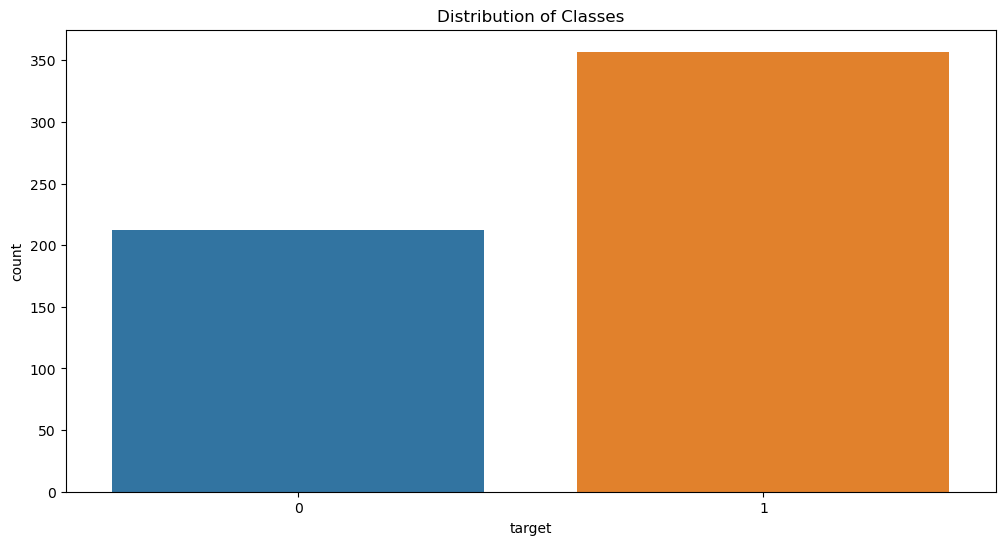

In [3]:
# EDA: Visualizing the distribution of classes and features
plt.figure(figsize=(12, 6))
sns.countplot(x='target', data=df)
plt.title('Distribution of Classes')
plt.show()

Here we can see the distribution of our classes.The vale "0" represents the malignant cases while "1" represents the benign cases.The dataset contains 569 instances withg 219 beeing **Malignant** and 357 beeing **Begning** and has 0 NULL values as we can see below.


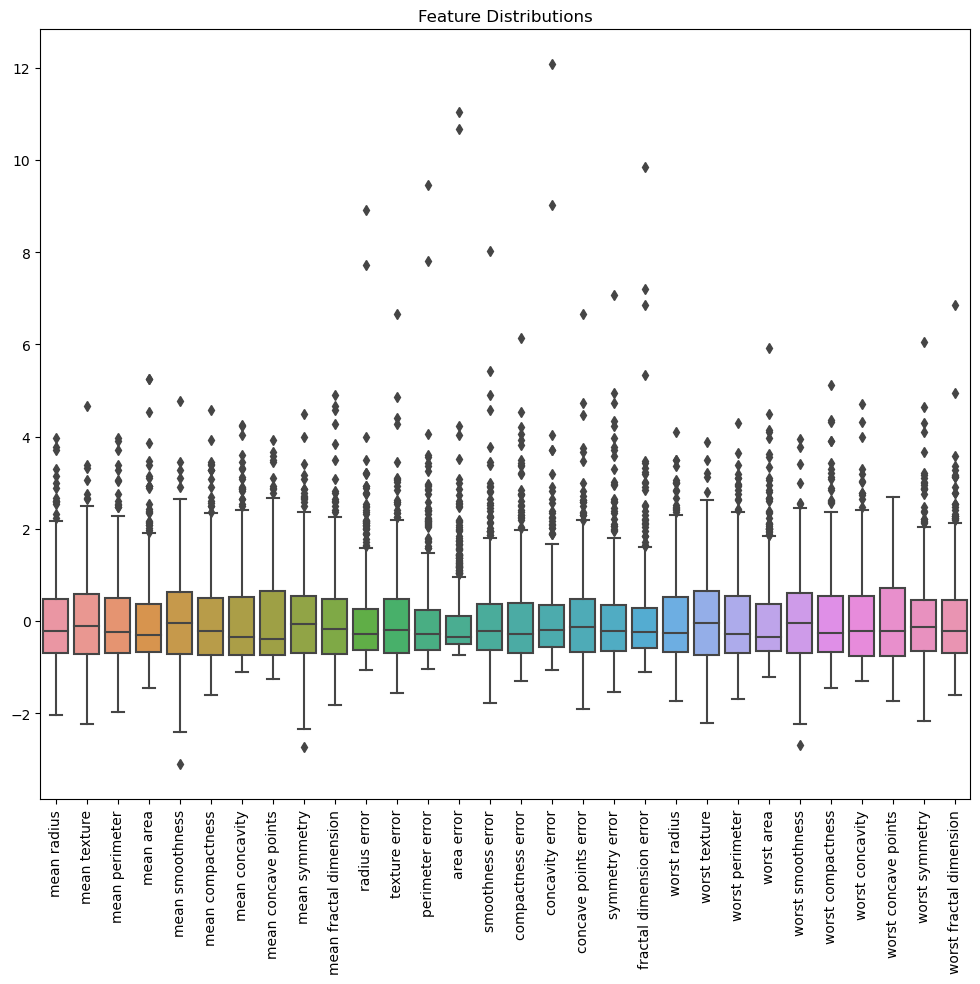

In [4]:
# Preprocessing: Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_df =  pd.DataFrame(X_scaled, columns=data.feature_names)

plt.figure(figsize=(12, 10))
sns.boxplot(x_df)

plt.xticks(rotation=90)
plt.title('Feature Distributions')
plt.show()


From the boxplot above we can identify the presence of many outliers.Most of them appear to be above the "whisker" which means they are displaying much higher values compared to the rest of the data's distribution, while we see a few below the "whisker" which means they are displaying much lower values compared to the rest of the data's distribution.

In [5]:
df.shape

(569, 31)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

We can see we have 0 null values!

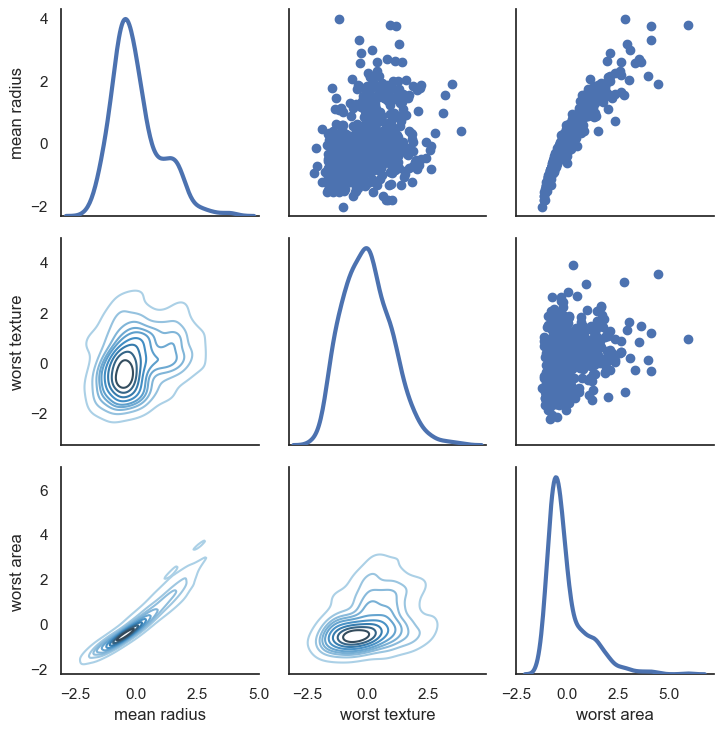

In [7]:
sns.set(style="white")
dd = x_df.loc[:,['mean radius','worst texture','worst area']]
g = sns.PairGrid(dd, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

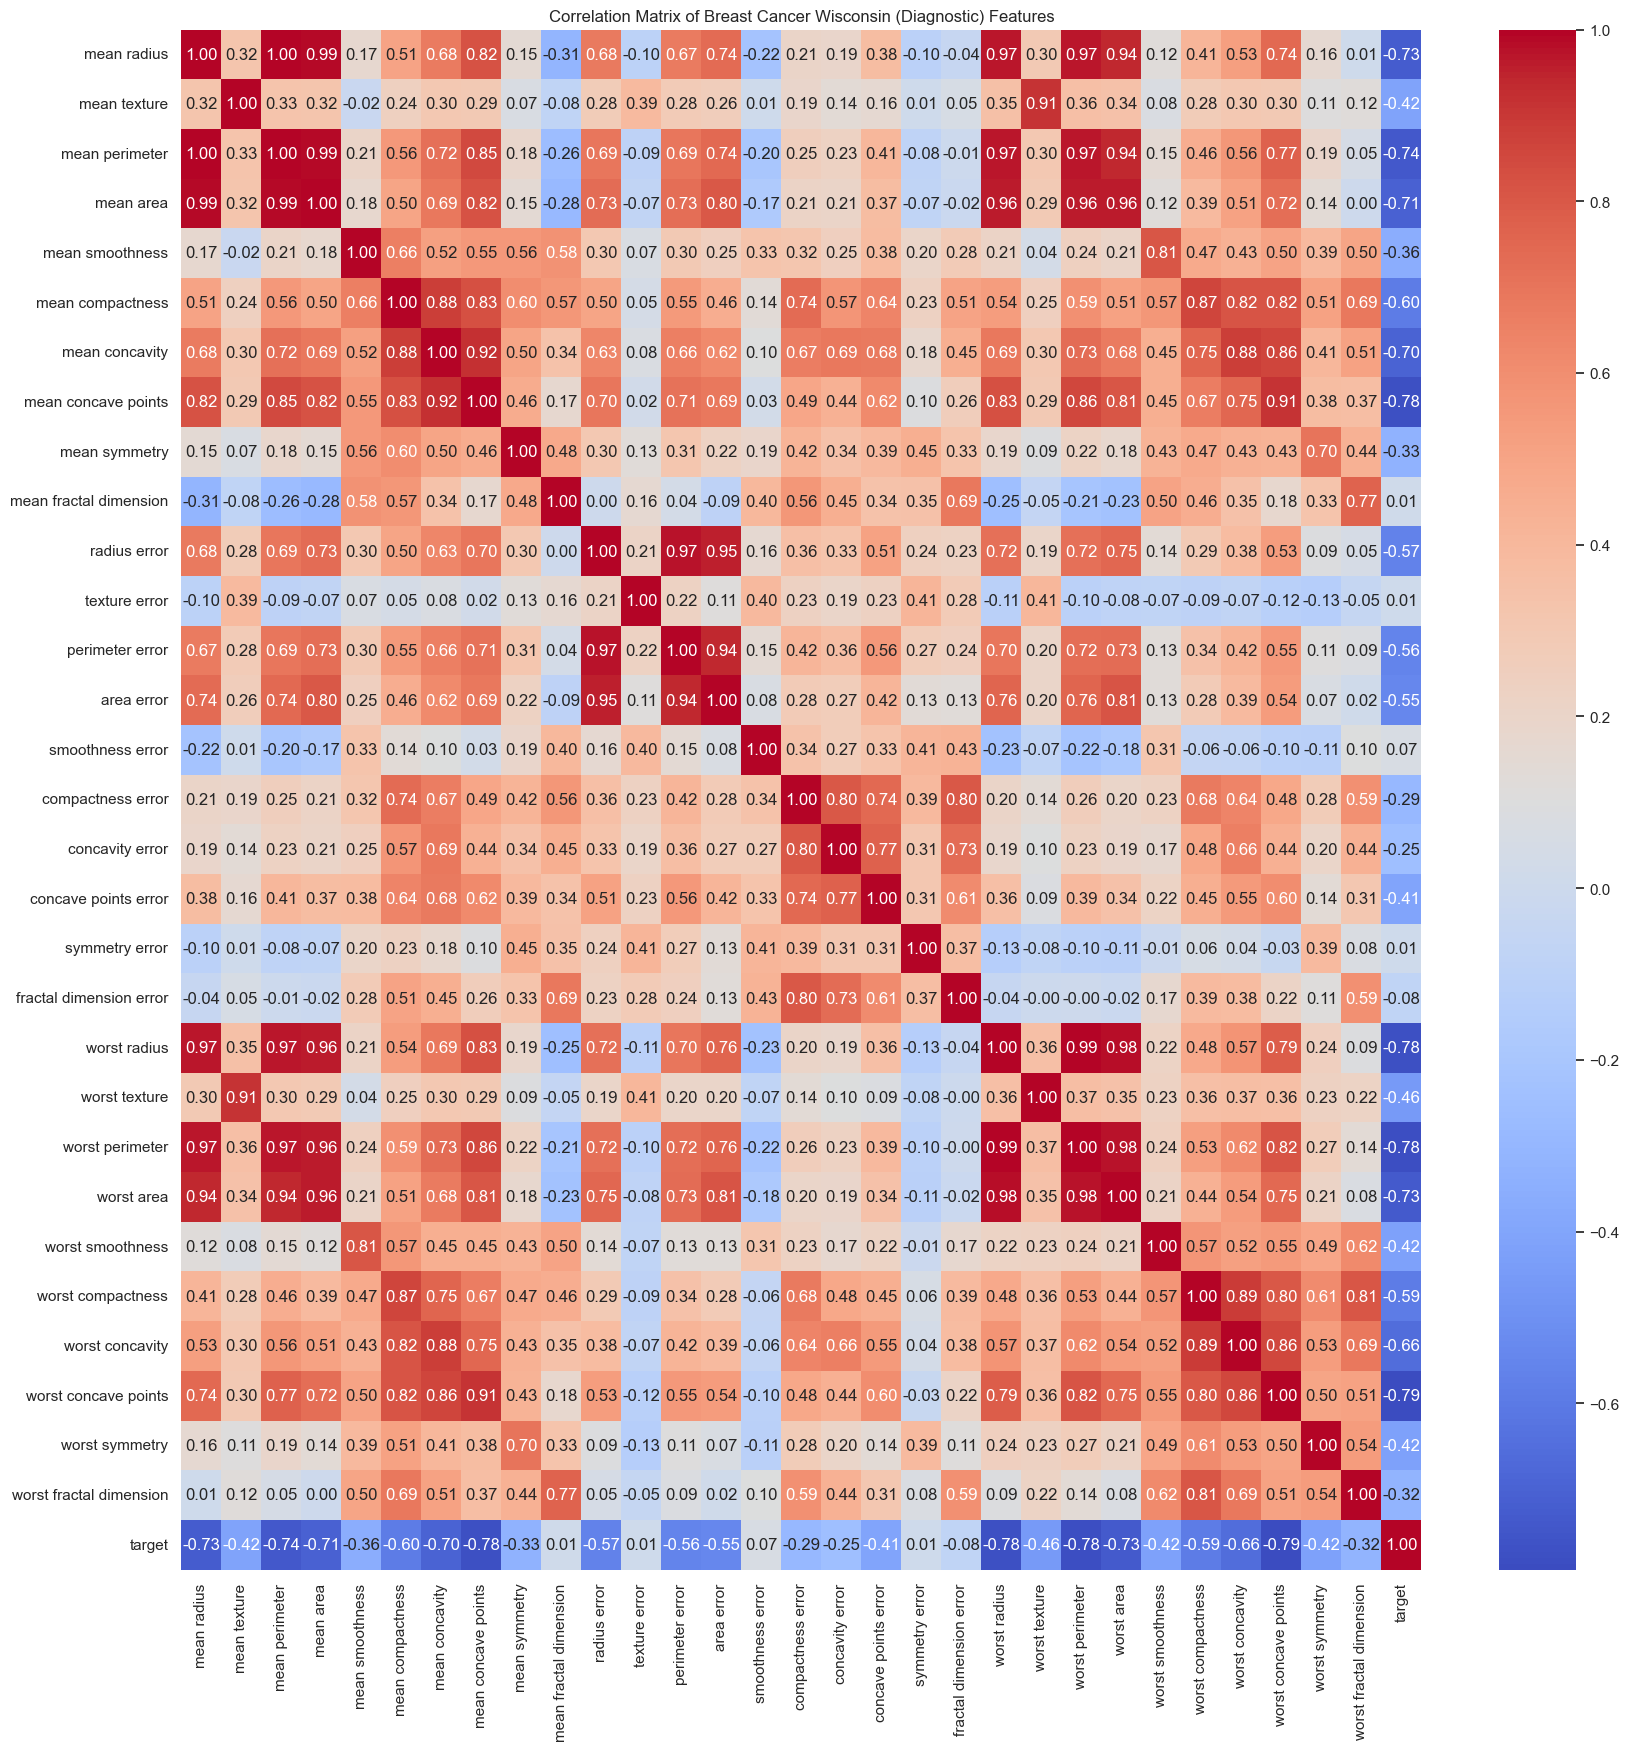

In [8]:
# Perform correlation analysis
correlation_matrix = df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Breast Cancer Wisconsin (Diagnostic) Features')
plt.show()

Above we see the correlation between our features in the dataset.It's evident that numerous features exhibit strong positive correlations with each other. Notably, it's worth highlighting that nearly all the features display a negative correlation with our target variable, except for "mean fractal dimension," "texture error," "smoothness error," and "symmetry error."

##  Removing the outliers

In [9]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, feature_names):
    for feature in feature_names:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

# Remove outliers from all features except the target column
features = data.feature_names
df_cleaned = remove_outliers_iqr(df, features)

# Check the shape of the original and cleaned dataset
print("Original dataset shape:", df.shape)
print("Cleaned dataset shape:", df_cleaned.shape)

Original dataset shape: (569, 31)
Cleaned dataset shape: (277, 31)


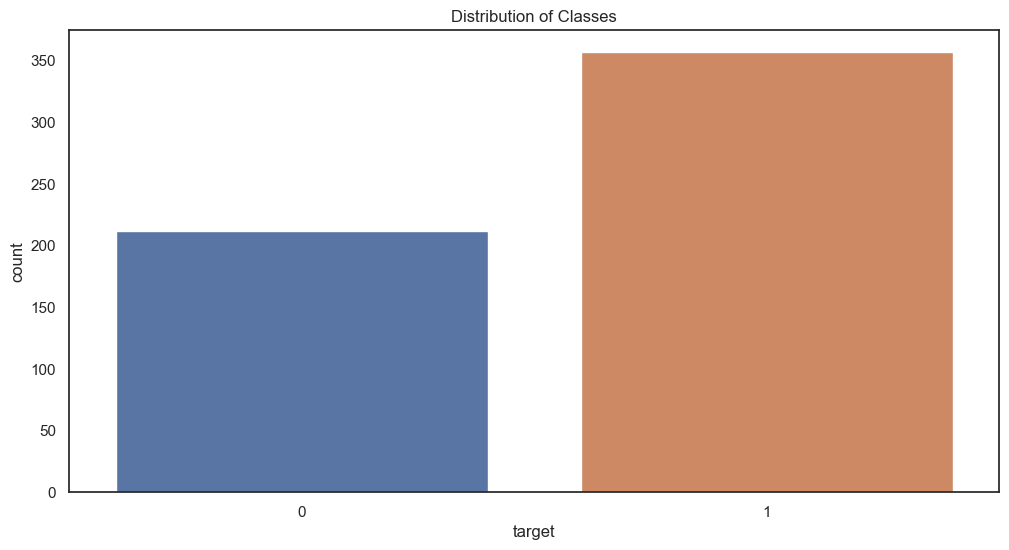

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(x='target', data=df)
plt.title('Distribution of Classes')
plt.show()

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Print class distribution before SMOTE
print("Class distribution before SMOTE:")
print(Counter(y_train))

# Apply SMOTE for oversampling the minority class in the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(Counter(y_train_smote))

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)  # Apply scaling to training data
X_test = scaler.transform(X_test)  # Apply the same scaling to test data

# Outputs for confirmation
print("\nShapes after SMOTE and scaling:")
print("X_train_smote shape:", X_train_smote.shape)
print("y_train_smote shape:", y_train_smote.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Class distribution before SMOTE:
Counter({1: 250, 0: 148})

Class distribution after SMOTE:
Counter({1: 250, 0: 250})

Shapes after SMOTE and scaling:
X_train_smote shape: (500, 30)
y_train_smote shape: (500,)
X_test shape: (171, 30)
y_test shape: (171,)


In this step, we used the SMOTE (Synthetic Minority Over-sampling Technique) algorithm to address the class imbalance in the training dataset. Before applying SMOTE, we observed the class distribution in the training set, which revealed an imbalance between the classes. SMOTE works by generating synthetic samples for the minority class, thereby rebalancing the dataset. After applying SMOTE, we confirmed the improved class distribution. Additionally, we normalized the features using StandardScaler, which ensures that all the features have the same scale, making the model training more efficient and stable. The final datasets, both for training and testing, were then ready for model development.

## SVM

In [ ]:
# Define the parameter grid for each kernel
param_grids = {
    'linear': {'kernel': ['linear'], 'C': [0.1, 1, 10, 20]},
    'poly': {'kernel': ['poly'], 'C': [0.1, 1, 10, 20], 'degree': [2, 3, 4, 5]},
    'rbf': {'kernel': ['rbf'], 'C': [0.1, 1, 10, 20], 'gamma': [0.1, 1, 2, 'auto']}
}

best_models = {}  # To store the best model for each kernel

# GridSearchCV for hyperparameter tuning for each kernel
for kernel, param_grid in param_grids.items():
    svm_model = SVC(probability=True)
    grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
    
    # Fit the grid search on the resampled and scaled training data (X_train_smote)
    grid_search.fit(X_train_smote, y_train_smote)
    
    best_models[kernel] = grid_search.best_estimator_  # Store the best model
    
    # Displaying the best hyperparameters for each kernel
    print(f"Best hyperparameters for {kernel.capitalize()} kernel:", grid_search.best_params_)

# Dictionary to store results and predictions
svm_results = {}
y_predSVM = {"linear": [], "poly": [], "rbf": []}

# Evaluating the best models on the test set for each kernel
for kernel, model in best_models.items():
    # Predict using the model on the scaled test set
    y_pred = model.predict(X_test)
    
    # Evaluation metrics for each kernel's best model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    y_predSVM[kernel] = y_pred  # Store predictions for each kernel
    svm_results[kernel] = {  # Store evaluation metrics
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

# Displaying the evaluation results in a DataFrame
pd.DataFrame(svm_results)


Best hyperparameters for Linear kernel: {'C': 0.1, 'kernel': 'linear'}
Best hyperparameters for Poly kernel: {'C': 20, 'degree': 3, 'kernel': 'poly'}
Best hyperparameters for Rbf kernel: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


,linear,poly,rbf
Accuracy,0.970760,0.941520,0.976608
Precision,0.981132,0.980198,0.990476
Recall,0.971963,0.925234,0.971963
F1 Score,0.976526,0.951923,0.981132
ROC-AUC,0.970356,0.946992,0.978169


Feature Importances Table:
                         Importance
texture error              0.287460
compactness error          0.231538
fractal dimension error    0.121748
symmetry error             0.099308
mean compactness           0.098949
perimeter error            0.071575
concavity error            0.031831
mean fractal dimension     0.008182
concave points error      -0.031408
mean smoothness           -0.036220
worst compactness         -0.043237
worst fractal dimension   -0.092667
mean symmetry             -0.185549
smoothness error          -0.199107
radius error              -0.203632
mean texture              -0.206417
mean concavity            -0.223293
mean concave points       -0.241595
mean perimeter            -0.290232
worst perimeter           -0.291219
worst concavity           -0.291427
worst smoothness          -0.307726
mean area                 -0.307877
mean radius               -0.309091
area error                -0.318675
worst concave points      -0.344048
w

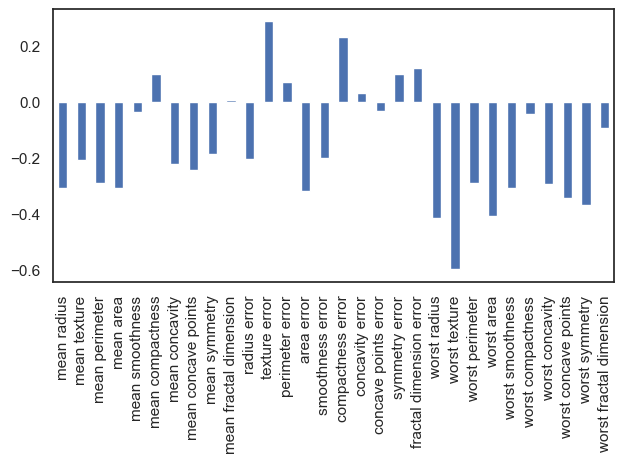

In [17]:
# Only for linear kernel because for others
# data is transformed by kernel method to another space.

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

svm = SVC(kernel='linear', C=0.1)
svm.fit(X_train_smote, y_train_smote)

importances = pd.Series(svm.coef_[0], index=data.feature_names)

fig, ax = plt.subplots()
importances.plot.bar( ax=ax)
fig.tight_layout()

# Extracting feature importances and displaying in a table in descending order
importances = pd.Series(svm.coef_[0], index=data.feature_names)
importances_df = pd.DataFrame(importances, columns=['Importance'])
importances_df = importances_df.sort_values(by='Importance', ascending=False)


# Printing the importance values in a table
print("Feature Importances Table:")
print(importances_df)

Analysis of feature importance employing a linear kernel SVM unveils the comparative importance of each feature in shaping the model's predictions. The bar chart visually represents the scale and orientation of influence for each feature. Longer bars denote greater influence on the classification outcome, with positive values signaling a leaning toward one class and negative values toward the other.In our case we can see that **compactness error,fractal and dimension error  texture error** are the most influential for choosing Benign(Represents non-cancerous tumours) while **mean concave points,worst symmetry and worst texture** for choosing Malignant(Represents cancerous tumours)

## Classification with Advanced Decision Trees

In [ ]:
# Classification with Advanced Decision Trees
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 400],
    'max_depth': [5, 10, 30, None]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5)
rf_grid.fit(X_train_smote, y_train_smote)  
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb_params = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 10, 30]
}
gb_grid = GridSearchCV(gb, gb_params, cv=5)
gb_grid.fit(X_train_smote, y_train_smote)  
gb_best = gb_grid.best_estimator_
y_pred_gb = gb_best.predict(X_test)

# Metrics for Random Forest and Gradient Boosting
rf_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_pred_rf)
}

gb_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_gb),
    'Precision': precision_score(y_test, y_pred_gb),
    'Recall': recall_score(y_test, y_pred_gb),
    'F1 Score': f1_score(y_test, y_pred_gb),
    'ROC-AUC': roc_auc_score(y_test, y_pred_gb)
}

# Combine results into a DataFrame
results = {'Random Forest': rf_metrics, 'Gradient Boosting': gb_metrics}
pd.DataFrame(results)

,Random Forest,Gradient Boosting
Accuracy,0.947368,0.953216
Precision,0.962264,0.954128
Recall,0.953271,0.971963
F1 Score,0.957746,0.962963
ROC-AUC,0.945386,0.946919


Feature Importances Table:
                         Importance
worst perimeter            0.148623
worst concave points       0.137304
worst area                 0.125166
mean concave points        0.095234
worst radius               0.062326
mean radius                0.059385
mean concavity             0.053166
mean perimeter             0.052325
worst concavity            0.043244
mean area                  0.036713
area error                 0.021108
mean compactness           0.020389
worst texture              0.019539
worst compactness          0.018630
worst smoothness           0.017338
mean texture               0.012176
mean smoothness            0.009937
worst symmetry             0.009301
radius error               0.009267
worst fractal dimension    0.007788
concave points error       0.006258
perimeter error            0.005408
concavity error            0.005072
smoothness error           0.004412
mean symmetry              0.004029
fractal dimension error    0.003794
t

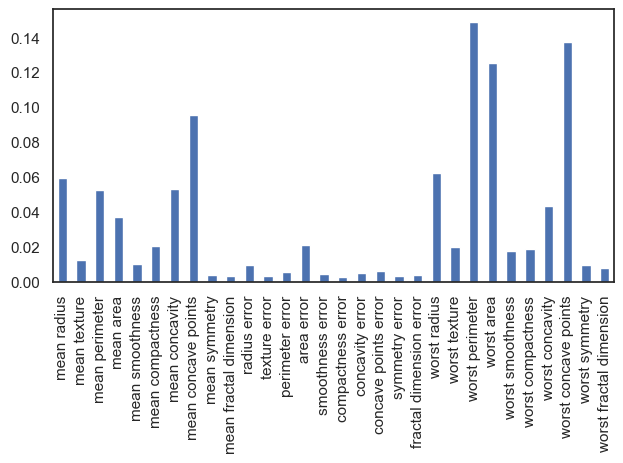

In [19]:
importances = pd.Series(rf_best.feature_importances_, index=data.feature_names)

fig, ax = plt.subplots()
importances.plot.bar( ax=ax)
fig.tight_layout()

# Creating a DataFrame for feature importances and printing as a table
importance_table = pd.DataFrame(importances, columns=['Importance'])
importance_table = importance_table.sort_values(by='Importance', ascending=False)
print("Feature Importances Table:")
print(importance_table)

The features contribute more significantly to the model's decision-making process is **worst concave points, worst area, and mean concave points** have relatively higher importance values,  On the other hand, features with lower importance values, such as **texture error, concave points error and mean symmetry** have less influence on the model's predictions.

## Model Comparison and Analysis


We saw how different parameters affected each model, now we are going to compare the models to see which one 
perfromed the best.



In [20]:
# Combine results
results = {'Random Forest': rf_metrics,
           'Gradient Boosting': gb_metrics, 
           'SVM_linear':svm_results['linear'],
           'SVM_poly':svm_results['poly'],
           'SVM_RBF':svm_results['rbf']
          }
pd.DataFrame(results)

,Random Forest,Gradient Boosting,SVM_linear,SVM_poly,SVM_RBF
Accuracy,0.947368,0.953216,0.970760,0.941520,0.976608
Precision,0.962264,0.954128,0.981132,0.980198,0.990476
Recall,0.953271,0.971963,0.971963,0.925234,0.971963
F1 Score,0.957746,0.962963,0.976526,0.951923,0.981132
ROC-AUC,0.945386,0.946919,0.970356,0.946992,0.978169


### Comparative Analysis of Model Performance

In this analysis, we compare the performance of multiple machine learning models—**Support Vector Machines (SVM)** with linear, polynomial, and radial basis function (RBF) kernels, and **ensemble methods** such as **Random Forest** and **Gradient Boosting**—on a rebalanced dataset using **SMOTE** (Synthetic Minority Over-sampling Technique) for handling class imbalance.

#### 1. **Model Accuracy and Precision**
   - **Accuracy** measures the proportion of correct predictions over all predictions. Among the models, **SVM with RBF kernel** achieved the highest accuracy at **97.66%**, followed by **Gradient Boosting** with **95.32%** and **Random Forest** with **94.74%**. The **linear** and **polynomial SVM kernels** lagged slightly behind, with accuracies of **97.08%** and **94.15%**, respectively.
   - **Precision** (the ratio of true positive predictions to total positive predictions) followed a similar trend. **SVM with RBF kernel** again topped the chart with **99.05%**, showing strong performance in correctly identifying the minority class, followed by **Random Forest** (**96.23%**) and **Gradient Boosting** (**95.41%**).

#### 2. **Recall and F1-Score**
   - **Recall** (the ratio of true positives to actual positives) reflects the model's ability to capture the minority class (often the more important class in imbalanced datasets). **Gradient Boosting** excelled in this area with a recall of **97.20%**, followed closely by **SVM with linear and RBF kernels** at **97.20%** and **97.20%** as well. The **polynomial kernel** achieved a slightly lower recall of **92.52%**.
   - **F1-Score**, which balances both precision and recall, shows **SVM with RBF kernel** performing best with an F1 of **98.11%**. This was closely followed by **Gradient Boosting** (**96.30%**) and **Random Forest** (**95.77%**). The **polynomial kernel** again exhibited the lowest F1 score at **95.19%**.

#### 3. **ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**
   - **ROC-AUC** evaluates the ability of the model to distinguish between classes. A higher score suggests that the model can better differentiate between positive and negative classes. The **SVM with RBF kernel** performed best with a **ROC-AUC of 97.82%**, followed by **SVM with linear kernel** (**97.04%**) and **Gradient Boosting** (**94.69%**). **Random Forest** had a slightly lower ROC-AUC score of **94.54%**, while the **polynomial kernel** scored **94.70%**.

#### 4. **Feature Importance and Interpretability**
   - In terms of **feature importance**, **Random Forest** and **Gradient Boosting** provided valuable insights. **Random Forest** highlighted features such as `worst perimeter`, `worst concave points`, and `worst area` as the most critical predictors of the target variable. Similarly, **Gradient Boosting** emphasized `worst perimeter`, `worst concave points`, and `worst area` in its decision-making process.
   - The feature importance rankings reveal that **both Random Forest and Gradient Boosting** were effective in leveraging relevant features, particularly those related to geometric properties like `area`, `perimeter`, and `concave points`.

#### 5. **Model Robustness and Performance Trade-Offs**
   - **SVM (with RBF kernel)** consistently outperformed other models across all metrics (accuracy, precision, recall, F1-score, and ROC-AUC). This suggests that **SVM** with RBF is highly effective at distinguishing between the two classes, likely due to its ability to handle non-linear decision boundaries. However, **SVM models are less interpretable** compared to **Random Forest** and **Gradient Boosting**, which are inherently more transparent, especially in terms of feature importance.
   - **Random Forest** and **Gradient Boosting** showed competitive performance with strong precision and recall, particularly in identifying positive cases (class 1), making them solid choices for imbalanced datasets. These models are also more robust to overfitting, especially with the tuning of hyperparameters (like `n_estimators`, `max_depth`, etc.).

#### 6. **Class Imbalance Handling via SMOTE**
   - The use of **SMOTE** has effectively rebalanced the class distribution, as evidenced by the change in class distribution from the original dataset (with a significant imbalance between class 0 and class 1) to the rebalanced dataset, where both classes had equal representation. The models were able to train on this balanced dataset, which contributed to the improvement in the performance metrics, particularly for models like **Random Forest** and **Gradient Boosting**.
   - The performance improvements observed across all models post-SMOTE indicate the importance of addressing class imbalance, as it directly impacts the model’s ability to generalize and make accurate predictions for both classes.

### Conclusion
The **SVM with RBF kernel** achieved the highest overall performance across most metrics, particularly **accuracy** and **ROC-AUC**, which makes it the best choice for this problem. However, **Random Forest** and **Gradient Boosting** are competitive alternatives, particularly when interpretability and feature importance are important considerations. SMOTE played a crucial role in enhancing the models' ability to handle the class imbalance, ensuring that both classes were adequately represented during training. Each of the models has its strengths and trade-offs, and the choice of model should depend on the specific requirements of the problem, such as the need for accuracy, interpretability, or the ability to handle complex decision boundaries.

Bellow you can see the plotted ROC curves and confusion matrices!


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title, ax):
    conf_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['FALSE', 'TRUE'],
                yticklabels=['FALSE', 'TRUE'], ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)

def plot_roc_curve_single_model(y_true, y_probs, label, linestyle='-', ax=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, linestyle, label=f'{label} (ROC= {roc_auc:.6f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver Operating Characteristic (ROC) Curve - {label}')
    ax.legend()



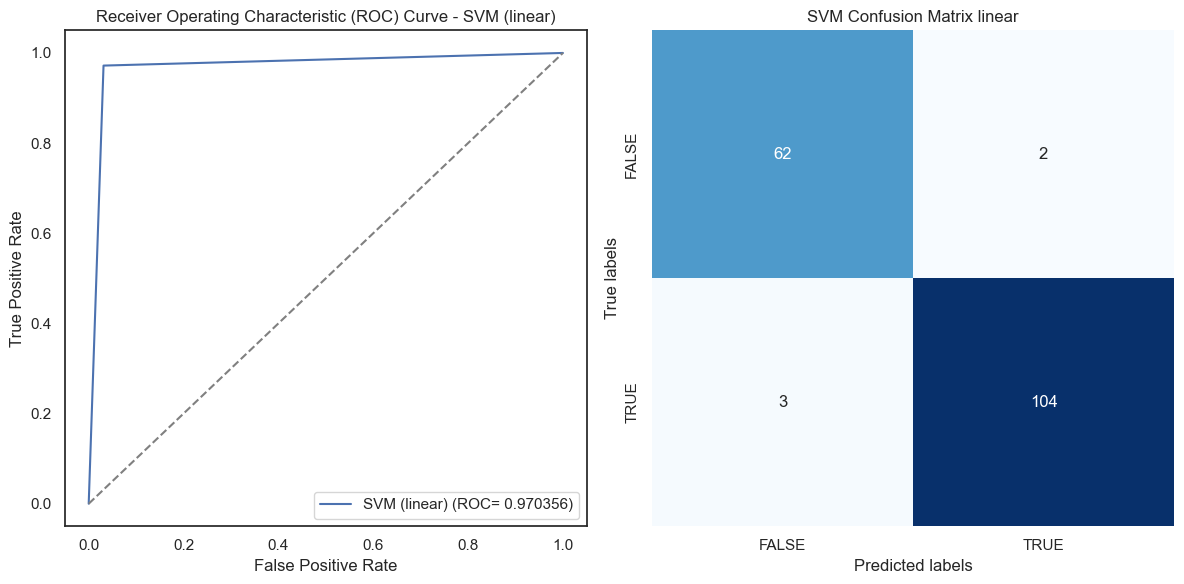

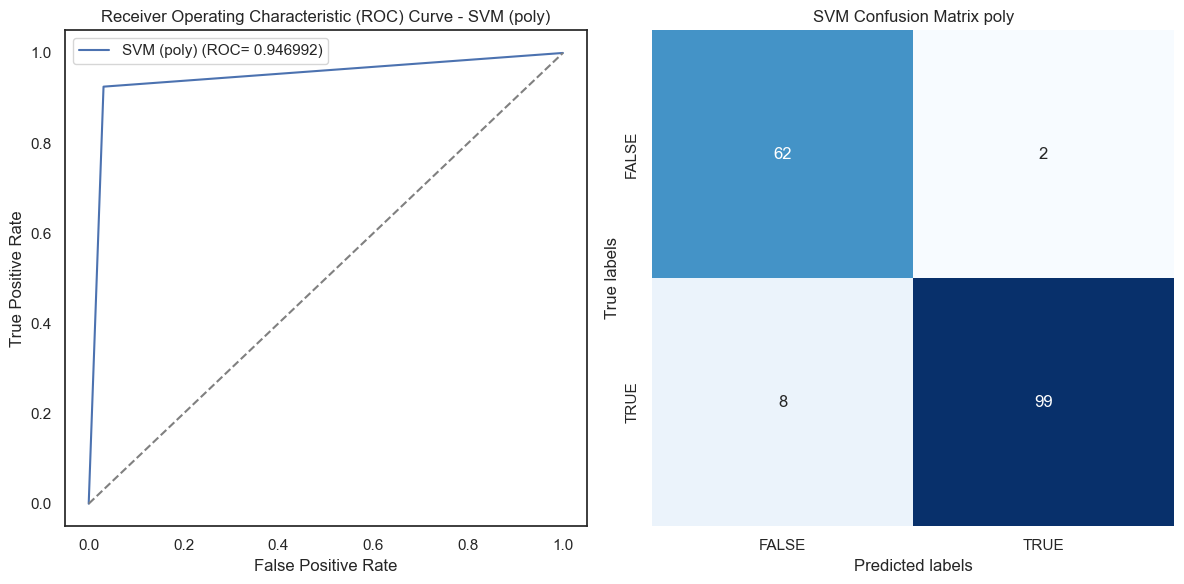

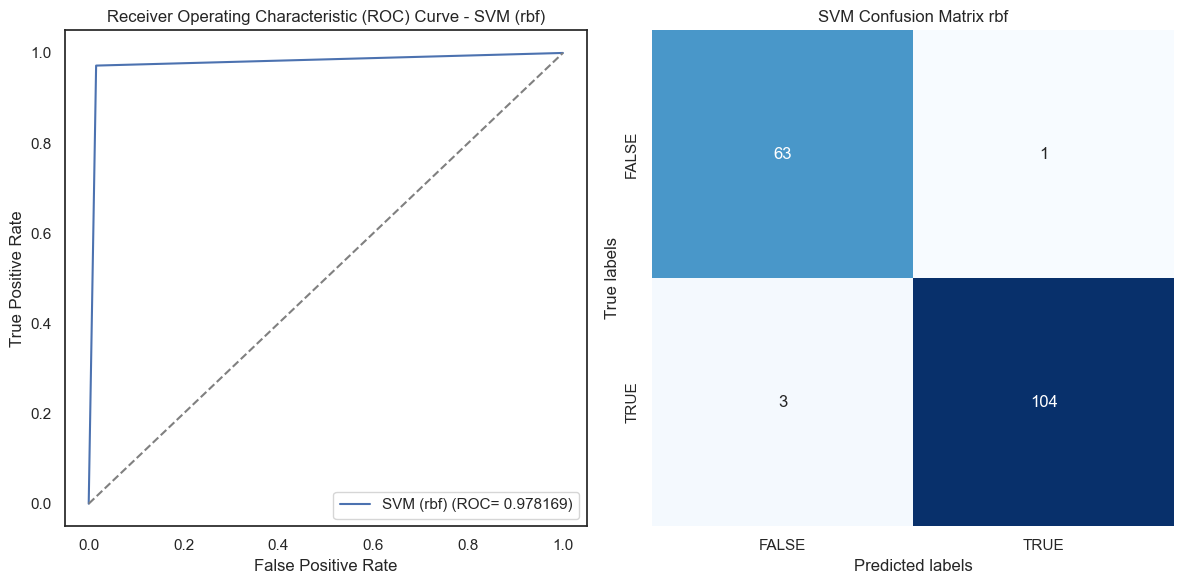

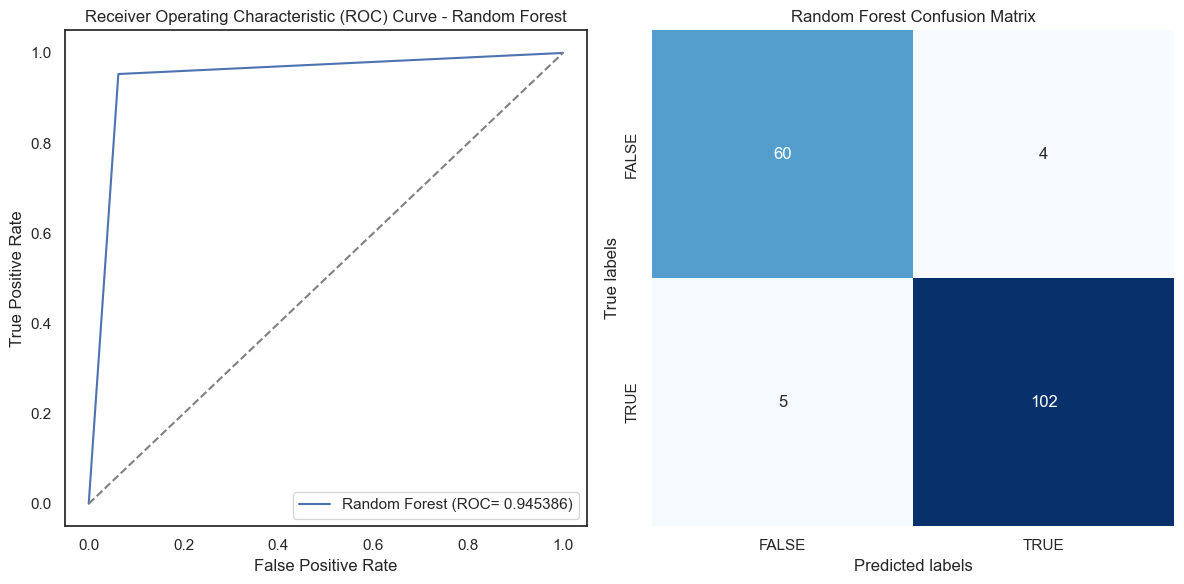

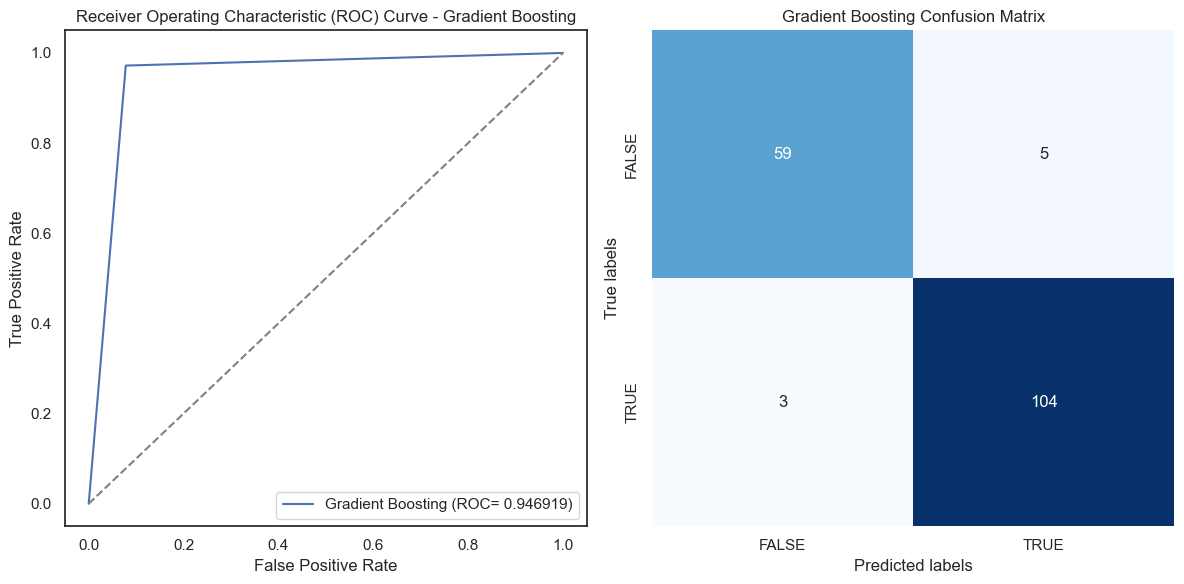

In [22]:

for kernel, y_pred in y_predSVM.items():
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    plot_roc_curve_single_model(y_test, y_pred, f'SVM ({kernel})',ax=axs[0])
    plot_confusion_matrix(y_test, y_pred, f'SVM Confusion Matrix {kernel}', ax=axs[1])
    
    plt.tight_layout()
    plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_roc_curve_single_model(y_test, y_pred_rf, 'Random Forest', ax=axs[0])
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest Confusion Matrix', ax=axs[1])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_roc_curve_single_model(y_test, y_pred_gb, 'Gradient Boosting', ax=axs[0])
plot_confusion_matrix(y_test, y_pred_gb, 'Gradient Boosting Confusion Matrix', ax=axs[1])

plt.tight_layout()
plt.show()

